In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer


In [2]:
df = pd.read_csv('./bank-full.csv', delimiter=';')

In [3]:
cols = ['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

features = cols.copy()
features.remove('y')

In [4]:
df = df[cols]
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
df.y = (df['y']=="yes").astype(int)

In [7]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [8]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=1)


In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
y_test = df_test.y.values
y_train = df_train.y.values
y_val = df_val.y.values

In [11]:
del df_train['y']
del df_val['y']
del df_test['y']

In [12]:
categorical_cols = list(df_train.dtypes[(df_train.dtypes == 'object').values].index)
numeric_cols = list(df_train.dtypes[(df_train.dtypes != 'object').values].index)

In [13]:
display(categorical_cols)
display(numeric_cols)

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Question 1: ROC AUC feature importance

In [14]:
scores = pd.DataFrame(columns=['feature','value'])
for col in numeric_cols:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    scores.loc[len(scores)] = [col, auc]

In [15]:
scores.sort_values(by='value',ascending=False)

,feature,value
3,duration,0.814700
6,previous,0.598565
5,pdays,0.590128
1,balance,0.588831
4,campaign,0.571454
2,day,0.525958
0,age,0.512186


# Question 2: Training the model

One hot encode:

In [16]:
train_dict = df_train[features].to_dict(orient='records')
val_dict = df_val[features].to_dict(orient='records')
test_dict = df_test[features].to_dict(orient='records')

In [17]:
dv = DictVectorizer(sparse=False)

In [18]:
X_train = dv.fit_transform(train_dict)
X_val = dv.fit_transform(val_dict)
X_test = dv.fit_transform(test_dict)

Train the model

In [19]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [20]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [21]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred_bin = model.predict(X_val)

In [22]:
from sklearn.metrics import auc

Calculate auc:

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr).round(2)

0.9

# Question 3: Precision and Recall

In [24]:
from sklearn.metrics import recall_score, precision_score

In [25]:
thresholds = np.arange(0,1,0.01)

In [26]:
(y_pred>=0.5)

array([False, False, False, ..., False, False, False])

In [27]:
scores = pd.DataFrame(columns=["threshold","precision","recall"])
for thres in thresholds:
    precision = precision_score(y_pred=y_pred>thres, y_true=y_val)
    recall = recall_score(y_pred=y_pred>thres, y_true=y_val)
    scores.loc[len(scores)] = [thres,precision,recall]

display(scores)

,threshold,precision,recall
0,0.00,0.121433,1.000000
1,0.01,0.135095,0.996357
2,0.02,0.158820,0.995446
3,0.03,0.186417,0.989982
4,0.04,0.219392,0.972678
...,...,...,...
95,0.95,0.677966,0.036430
96,0.96,0.638298,0.027322
97,0.97,0.625000,0.022769
98,0.98,0.677419,0.019126


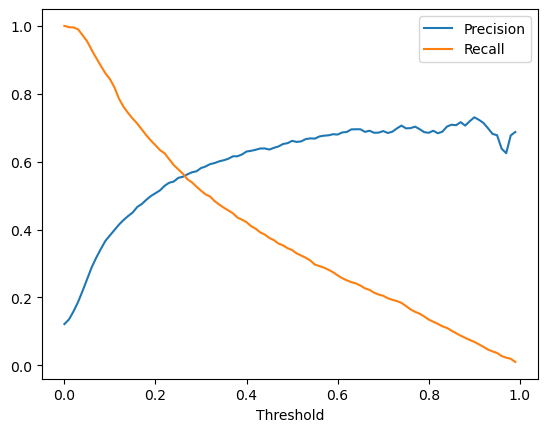

In [28]:
plt.xlabel("Threshold")
plt.plot(thresholds, scores.precision, label = "Precision")
plt.plot(thresholds, scores.recall, label = "Recall")
plt.legend()

# Question 4: F1 score

In [29]:
scores = pd.DataFrame(columns=["threshold","precision","recall","f1"])
for thres in thresholds:
    precision = precision_score(y_pred=y_pred>thres, y_true=y_val)
    recall = recall_score(y_pred=y_pred>thres, y_true=y_val)
    f1 = 2*(precision*recall)/(precision+recall)
    scores.loc[len(scores)] = [thres,precision,recall,f1]

display(scores.sort_values(by="f1",ascending=False))

,threshold,precision,recall,f1
22,0.22,0.528913,0.624772,0.572860
23,0.23,0.537903,0.607468,0.570573
20,0.20,0.507123,0.648452,0.569145
19,0.19,0.498970,0.662113,0.569080
21,0.21,0.515556,0.633880,0.568627
...,...,...,...,...
95,0.95,0.677966,0.036430,0.069144
96,0.96,0.638298,0.027322,0.052402
97,0.97,0.625000,0.022769,0.043937
98,0.98,0.677419,0.019126,0.037201


# Question 5: Kfold

In [30]:
from sklearn.model_selection import KFold

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [35]:
scores = pd.DataFrame(columns=["fold", "auc"])
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
for index,(train_idx, val_idx) in enumerate(kfold.split(df_train_full)):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    y_train = df_train.y.values
    y_val = df_val.y.values

    train_dict = df_train[categorical_cols+numeric_cols].to_dict(orient='records')
    val_dict = df_val[categorical_cols+numeric_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    X_val = dv.fit_transform(val_dict)

    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    auc_score = roc_auc_score(y_val, y_pred)

    scores.loc[len(scores)] = [index,auc_score]

    
    

In [36]:
display(scores)
display(round(np.std(scores.auc),4))

,fold,auc
0,0.0,0.652185
1,1.0,0.654611
2,2.0,0.668686
3,3.0,0.656727
4,4.0,0.662464


0.0059

# Question 6: Hyperparameter Tuning

In [34]:
scores = pd.DataFrame(columns=["C","mean","std"])

for C in [0.000001, 0.001, 1]:
    aucs = []
    for index,(train_idx, val_idx) in enumerate(kfold.split(df_train_full)):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
        y_train = df_train.y.values
        y_val = df_val.y.values

        train_dict = df_train[categorical_cols+numeric_cols].to_dict(orient='records')
        val_dict = df_val[categorical_cols+numeric_cols].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dict)
        X_val = dv.fit_transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        aucs.append(roc_auc_score(y_val,y_pred))
    scores.loc[len(scores)] = [C,np.mean(aucs),np.std(aucs)]

display(scores)
    

,C,mean,std
0,0.000001,0.536333,0.004778
1,0.001000,0.584637,0.006689
2,1.000000,0.658935,0.005944
